# 6. The Laplacian Pyramid

In [101]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image

## 6.1 The basic concept

<figure id="figure-2">
<div style="background-color: white">

![](figures/laplacian.svg)</div>
    
<figcaption style="text-align: center">Figure 2: A typical laplacian pyramid with 2 levels; forward (analysis) part only</figcaption>
</figure>

The Laplacian pyramid is an energy compaction technique, based on
the observation:

> For most real-world images, the high-frequency energy is much less than the low-frequency energy.

Since the lowpass image is much lower bandwidth than the
original image, it can be subsampled (*decimated*) 2:1 in both
horizontal and vertical directions, without significant loss of
information to give a quarter-size lowpass image.  We have
provided a row filter/decimation function, `rowdec(X, h)`, to
filter and decimate the rows of a matrix by 2:1.

In [102]:
from cued_sf2_lab.laplacian_pyramid import rowdec

Use this twice
(on the image and its transpose) to generate a quarter-size
lowpass image `X1` of Lighthouse.  For simplicity use a 3-tap (length 3)
filter `h` with coefficients: $\frac{1}{4} [1\ 2\ 1]$.

In [103]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})

In [104]:
print(X)

[[124 117 119 ... 140 144 149]
 [119 117 118 ... 151 150 153]
 [121 117 120 ... 158 159 159]
 ...
 [207 213 215 ...  31  36  40]
 [212 214 213 ...  53  53  58]
 [214 213 213 ...  65  69  62]]


In [105]:
h = 0.25*np.array([1, 2, 1])
X1_row = rowdec(X, h)
X1 = rowdec(X1_row.T, h)

X1 = X1.T

The image `X1` can be interpolated 2:1 in each direction to
generate a lowpass image of the original size, which can then be
subtracted from the original to yield a full-size highpass image.
We have also provided a row interpolation/filter function,
`rowint(X, h)`, which doubles the length of each row of the image, by
inserting zeros between alternate samples and then lowpass
filtering the result with the filter `h`. Note that to undo the decimation
performed by `Y = rowdec(X, h)`, this should be called as `Z = rowint(Y, 2*h)`,
where a DC gain of 2 is added, as shown in [Figure 2](#figure-2).

In [106]:
from cued_sf2_lab.laplacian_pyramid import rowint

Apply this twice (as before) to generate
a full-size lowpass image, and subtract this from `X` to
give a highpass image `Y0`. Display `X1` and `Y0` to see these effects.

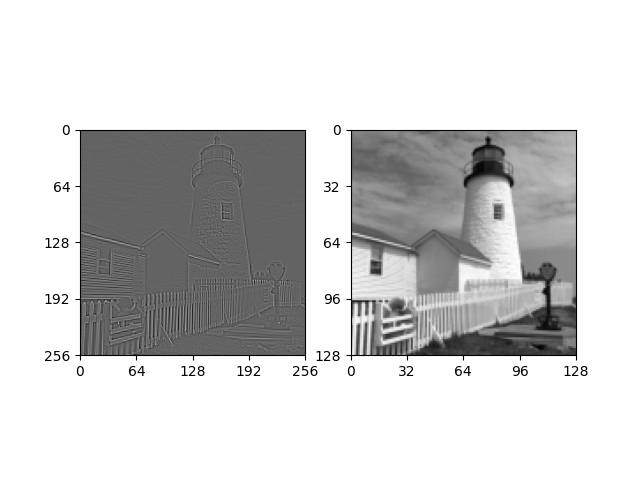

In [107]:
# your code here
Z_row = rowint(X1, 2*h)
Z = rowint(Z_row.T, 2*h)

Z = Z.T

Y0 = X - Z

fig, ax = plt.subplots(1,2)
plot_image(Y0, ax=ax[0]);
plot_image(X1, ax=ax[1]);

The highpass images will
always have approximately zero mean (since any dc component is
removed). Hence for the remainder of this project, we recommend
that you also make all lowpass images be approximately zero mean
by subtracting 128 from them before you start any processing. This
makes the 8-bit pixel values cover the range -128 to 127,
instead of 0 to 255. The advantages of having a zero-mean input image are not very obvious here, but they
will become clearer as the project progresses. If you use `draw_image` the images will still be displayed correctly.

In [108]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

Examine the functions ```rowdec``` and ```rowint``` and check that you understand how they work. Decimation is achieved by selecting every second element of a vector using selection indices `i:i+c:2`, and filtering is performed with symmetric extension as in ```convse```, except that we do not bother to calculate the filter outputs that are to be discarded by the decimation process. Interpolation is achieved by loading every second element of a double-size vector using `X2 = np.zeros((r, c2), dtype=X.dtype)`, `X2[:, ::2] = X`. The intermediate samples of the interpolated vector x must be zero before the vector is passed through the interpolation filter.

In [109]:
IPython.display.Code(inspect.getsource(rowdec), language="python")

def rowdec(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Filter rows of image X with h and then decimate by a factor of 2.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Image with filtered and decimated rows

    If len(H) is odd, each output sample is aligned with the first of
    each pair of input samples.
    If len(H) is even, each output sample is aligned with the mid point
    of each pair of input samples.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    if m % 2:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='reflect')
    else:
        X = np.pad(X, [(0, 0), (m2-1, m2-1)], mode='symmetric')

    Y = np.zeros((r, (c+1)//2))
    # Loop for each term in h.
    for i in range(m):
        Y = Y + h[i] * X[:, i:i+c:2]
    return Y

In [110]:
IPython.display.Code(inspect.getsource(rowint), language="python")

def rowint(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Interpolates the rows of image X by 2 using h.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Image with interpolated rows

    If len(h) is odd, each input sample is aligned with the first of
    each pair of output samples.
    If len(h) is even, each input sample is aligned with the mid point
    of each pair of output samples.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    c2 = 2 * c

    # Generate X2 as X interleaved with columns of zeros.
    X2 = np.zeros((r, c2), dtype=X.dtype)
    X2[:, ::2] = X

    X2 = np.pad(X2, [(0, 0), (m2, m2)], mode='reflect' if m % 2 else 'symmetric')

    Y = np.zeros((r, c2))
    # Loop for each term in h.
    for i in range(m):
        Y = Y + h[i] * X2[:, i:i+c2]
    return Y

If the small lowpass image `X1` and the full-size highpass image `Y0`
are transmitted to a distant decoder, then the decoder can exactly reconstruct
the original image by interpolating `X1` up to full size and adding in
`Y0` (which represents the error between the original and the interpolated
`X1`).  We have achieved image compression if `X1` and `Y0` can be
transmitted with fewer bits than `X`.  Usually this will be the case
because `Y0` contains so much less energy than `X`, and `X1` is
only one quarter of the size of `X`.  However we do start at a
disadvantage because there are 25% more samples to code.  Many of the `Y0` samples may be represented by zero, and we shall show later that runs of
zeros may be coded with relatively few bits.

The quarter-size lowpass image `X1` may be further subsampled, using the
same process as was applied to `X`, so that it may be transmitted as a
one-sixteenth-size lowpass image `X2` and a quarter-size highpass image
`Y1`.  This usually achieves further data compression and may be repeated
as many times as is desired (until, for typical images, no further compression
is achieved).  This leads to a pyramid of highpass images and a final tiny
lowpass image.  Usually three or four layers of the pyramid are sufficient to
give maximum compression.

Write a `py4enc(X, h)` function to generate a 4-layer pyramid, so that `X` is split into four
highpass images, `Y0 Y1 Y2 Y3`, each a quarter of the size of its predecessor, plus a tiny
lowpass image `X4`, which is a quarter of the size of `Y3`.

In [111]:
def py4enc(X, h):
    # your code here

    X1 = rowdec(rowdec(X, h).T, h).T
    X2 = rowdec(rowdec(X1, h).T, h).T
    X3 = rowdec(rowdec(X2, h).T, h).T
    X4 = rowdec(rowdec(X3, h).T, h).T


    Y0 = X - rowint(rowint(X1, 2*h).T, 2*h).T
    Y1 = X1 - rowint(rowint(X2, 2*h).T, 2*h).T
    Y2 = X2 - rowint(rowint(X3, 2*h).T, 2*h).T
    Y3 = X3 - rowint(rowint(X4, 2*h).T, 2*h).T

    # remove these lines when implementing your code - they are here to show you what shape the plots below should be
    '''
    Y0 = np.full(X.shape, np.nan)
    Y1 = np.full(X.shape >> np.int_(1), np.nan)
    Y2 = np.full(X.shape >> np.int_(2), np.nan)
    Y3 = np.full(X.shape >> np.int_(3), np.nan)
    X4 = np.full(X.shape >> np.int_(4), np.nan)
    '''
    
    return Y0, Y1, Y2, Y3, X4

We can then plot the results to check them using the `beside` helper function:

In [112]:
from cued_sf2_lab.laplacian_pyramid import beside

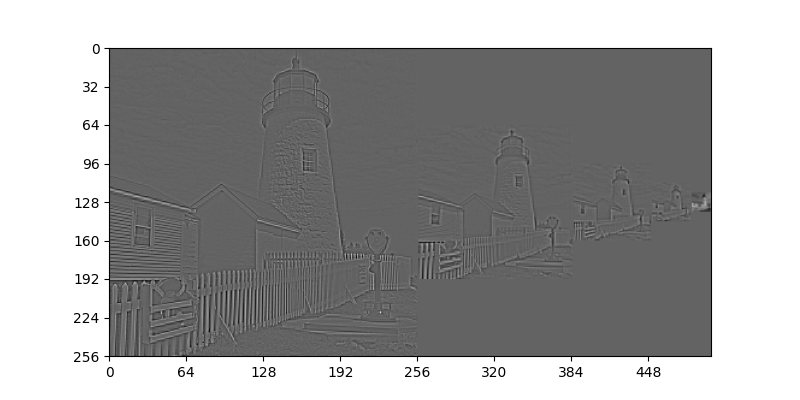

In [113]:
Y0, Y1, Y2, Y3, X4 = py4enc(X, h)
fig, ax = plt.subplots(figsize=(8, 4))
plot_image(beside(Y0, beside(Y1, beside(Y2, beside(Y3, X4)))), ax=ax);

If we wish to see the images separately from each other, instead of using our `beside` function that was written to match the old Matlab version, we can draw this directly with `matplotlib` using [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to create a set of subplots, and the `width_ratios` argument to [`GridSpec`](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html):

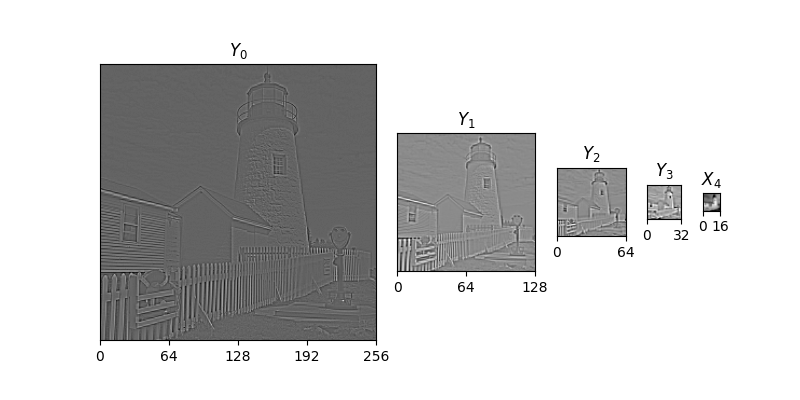

In [114]:
titles = ["Y_0", "Y_1", "Y_2", "Y_3", "X_4"]
imgs = [Y0, Y1, Y2, Y3, X4]
fig, axs = plt.subplots(1, 5, figsize=(8, 4),
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

If we wish to see the images at the same scale as each other, we can use:

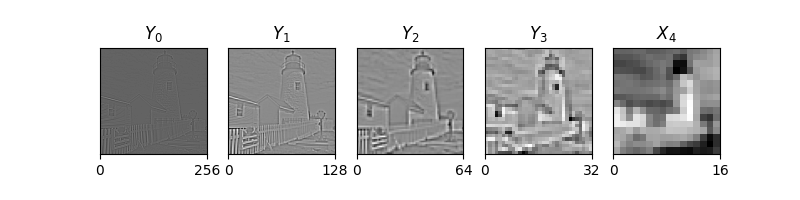

In [115]:
titles = ["Y_0", "Y_1", "Y_2", "Y_3", "X_4"]
imgs = [Y0, Y1, Y2, Y3, X4]
fig, axs = plt.subplots(1, 5, figsize=(8, 2))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

Get a demonstrator to check that your images look correct, and
then write another function `py4dec` to decode `X4` and
`Y3 Y2 Y1 Y0` into a set of lowpass images `Z3 Z2 Z1 Z0`.
(`Z3` is obtained by interpolating `X4` and adding
`Y3`, and then `Z2` is obtained from `Z3` and `Y2`, and
so on.)

In [116]:
def py4dec(Y0, Y1, Y2, Y3, X4, h):
    # your code here
    Z3 = rowint(rowint(X4, 2*h).T, 2*h).T + Y3
    Z2 = rowint(rowint(Z3, 2*h).T, 2*h).T + Y2
    Z1 = rowint(rowint(Z2, 2*h).T, 2*h).T + Y1
    Z0 = rowint(rowint(Z1, 2*h).T, 2*h).T + Y0

    # remove these lines when implementing your code - they are here to show you what shape the plots below should be
    '''
    Z0 = np.full(Y0.shape, np.nan)
    Z1 = np.full(Y0.shape >> np.int_(1), np.nan)
    Z2 = np.full(Y0.shape >> np.int_(2), np.nan)
    Z3 = np.full(Y0.shape >> np.int_(3), np.nan)
    '''
    
    return Z3, Z2, Z1, Z0

If all is correct, `Z0` should be identical to
`X`.  You can check that your function is correct by calculating `np.max(abs(X - Z0))` and also displaying your pyramid of decoded images, `Z3` to `Z0`.

Encode-Decode Error = 0.0


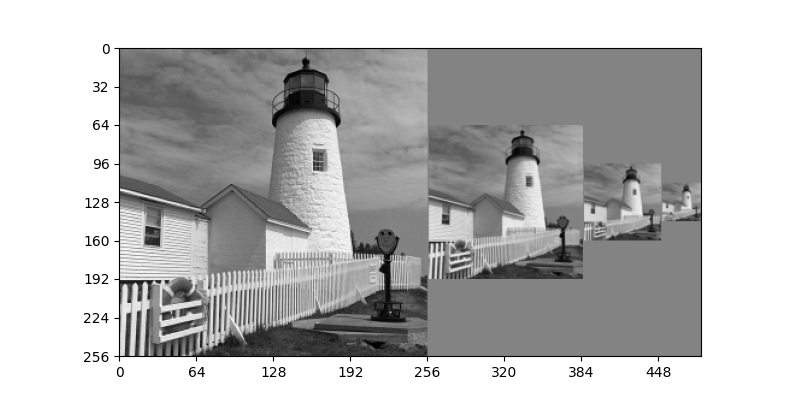

In [117]:
h = 0.25*np.array([1, 2, 1])
Z3, Z2, Z1, Z0 = py4dec(Y0, Y1, Y2, Y3, X4, h)
encode_decode_err = np.max(np.abs(X - Z0))
print(f'Encode-Decode Error = {encode_decode_err}')

# your code here to plot the images
fig, ax = plt.subplots(figsize=(8, 4))
plot_image(beside(Z0, beside(Z1, beside(Z2, Z3))), ax=ax);


For further information on the Laplacian Pyramid see Burt and Adelson [IEEE Trans. on Communications, 1983, vol 31, no 4, pp 532-540, "The Laplacian Pyramid as a compact image code"].

## 6.2 Quantisation and Coding Efficiency
To see whether data compression is possible using the above pyramid decomposition, we must calculate the approximate number of bits required to code the image pyramid. This may be done using the *entropy* of the quantised image data. 

The entropy of a single data sample, whcih may randomly take one of $Q$ possible quantised values such that each value $q(i)$ has a probability $p(i)$ of being in state $i$ for $i=1\to Q$ is given by:

$$ \text{Entropy (bits/sample)} = \sum_{i=1}^Qp(i) \log_2\frac{1}{p(i)} = -\sum_{i=1}^Q p(i) \log_2p(i)$$

The entropy represents the minimum average number of bits per sample needed to code samples with the given probability distribution $p(i)$, assuming that an ideal variable-length entropy code is used, and that the samples are uncorrelated with each other. Arithmetic codes can get arbitrarily close to this bit rate, and simpler Huffman codes can also get vary close with many typical signals (you will be using Huffman codes later on). It is possible to code signals at bit rates less than the entropy, if the samples are correlated, but for simplicity we shall ignore this here.

To demonstrate the validity of the above formula, first consider a signal with 8 quantised values of equal probability $p(i) = 1/8$ for all $i$. The entropy is then $8 \times 1/8 \times \log_2(8) = 3$ bits per sample, as expected. 

Now consider a signal with only 3 values, with probabilities $p(1)=1/2$,  $p(2) = p(3) = 1/4$. The entropy is then $\frac{1}{2} \log_2(2) + 2 \times \frac{1}{4} \log_2(4) = 1.5$ bits per sample. This is consistent with using a single bit '0' to represent state 1 and two bits, '10' and '11' to represent states 2 and 3.

The function `bpp` has been written to calculate the entropy in bits per pixel of an image matrix `X`. First the function computes a histogram of `X` to determine the probabilities $p(i)$ and then it calculates the entropy, using the above formula.

In [118]:
from cued_sf2_lab.laplacian_pyramid import bpp

In the Laplacian Pyramid, the total number of bits is obtained by multiplying each of the sub-image entropies by the number of pixels in each corresponding sub-image. However, in order to compress the data, we also need to quantise the images. We have also provided a function `quantise` which will quantise `X` in steps centred on integer multiples of `step`. Hence `bpp(quantise(X, step))` will return the entropy of image `X` quantised in steps of `step`.

In [119]:
from cued_sf2_lab.laplacian_pyramid import quantise

<div class="alert alert-block alert-danger">

Calculate the entropies of images `X` `X1` `Y0` and hence the total numbers of bits to encode `X`, or `X1` and `Y0`, when quantised to a step size of 17 (which gives 15 distict grey levels if applied to a lowpass image with intensities from -127 to 127. Find the data compression for this simple one-stage pyramid, and then investigate the improvements from using more layers.
</div>

In [120]:
# Write your code to calculate compression ratios here.
H_X = bpp(quantise(X,17))
H_X1 = bpp(quantise(X1,17))
H_Y0 = bpp(quantise(Y0,17))

H_X_bits = H_X * X.shape[0]**2
H_X1_bits = H_X1 * X1.shape[0]**2
H_Y0_bits = H_Y0 * Y0.shape[0]**2


print("Entropies: ", H_X, H_X1, H_Y0)
print("Total Bits ", H_X_bits, H_X1_bits, H_Y0_bits, H_X1_bits+H_Y0_bits)

dc_ratio_1 = H_X_bits/(H_X1_bits + H_Y0_bits)
print("Data Compression Ratio with 1 layer:", dc_ratio_1)

H_X4 = bpp(quantise(X4,17))
H_Y1 = bpp(quantise(Y1,17))
H_Y2 = bpp(quantise(Y2,17))
H_Y3 = bpp(quantise(Y3,17))

H_X4_bits = H_X4 * X4.shape[0]**2
H_Y1_bits = H_Y1 * Y1.shape[0]**2
H_Y2_bits = H_Y2 * Y2.shape[0]**2
H_Y3_bits = H_Y3 * Y3.shape[0]**2

dc_ratio_4 = H_X_bits/(H_X4_bits + H_Y0_bits + H_Y1_bits + H_Y2_bits + H_Y3_bits)
print("Data Compression Ratio with 4 layers:", dc_ratio_4)


Entropies:  3.480820259379386 3.402104341673226 1.620836817010486
Total Bits  228119.03651868744 55740.07753397414 106223.16163959922 161963.23917357335
Data Compression Ratio with 1 layer: 1.4084618070290382
Data Compression Ratio with 4 layers: 1.6608214118976627


In [121]:
def py_enc(X, h, num_layers):
    Y_layers = []
    current_image = X
    for _ in range(num_layers):
        downsampled = rowdec(rowdec(current_image, h).T, h).T
        laplacian_layer = current_image - rowint(rowint(downsampled, 2*h).T, 2*h).T
        Y_layers.append(laplacian_layer)
        current_image = downsampled
    return Y_layers, current_image

def py_dec(Y_layers, base_layer, h, step_size):
    current_image = quantise(base_layer, step_size)
    for laplacian_layer in reversed(Y_layers):
        current_image = rowint(rowint(current_image, 2*h).T, 2*h).T + quantise(laplacian_layer, step_size)
    return current_image

H_X_bits = bpp(quantise(X, 17)) * X.shape[0]**2

compression_ratios = {}

for num_layers in range(1, 8):
    step_size = 17
    Y_layers, low_pass = py_enc(X, h, num_layers)
    
    H_lp_bits = bpp(quantise(low_pass, step_size)) * low_pass.shape[0]**2
    H_Y_layers_bits = sum(bpp(quantise(Y, step_size)) * Y.shape[0]**2 for Y in Y_layers)
    
    dc_ratio = H_X_bits / (H_lp_bits + H_Y_layers_bits)
    compression_ratios[num_layers] = dc_ratio
    print(f"Data Compression Ratio with {num_layers} layer(s):", dc_ratio)

print("Compression Ratios for each number of layers:", compression_ratios)

Data Compression Ratio with 1 layer(s): 1.406814651240581
Data Compression Ratio with 2 layer(s): 1.599247333158242
Data Compression Ratio with 3 layer(s): 1.6498864463331369
Data Compression Ratio with 4 layer(s): 1.6608214118976632
Data Compression Ratio with 5 layer(s): 1.662104532853784
Data Compression Ratio with 6 layer(s): 1.6620473912592661
Data Compression Ratio with 7 layer(s): 1.6620045780266717
Compression Ratios for each number of layers: {1: 1.406814651240581, 2: 1.599247333158242, 3: 1.6498864463331369, 4: 1.6608214118976632, 5: 1.662104532853784, 6: 1.6620473912592661, 7: 1.6620045780266717}


Since compressing an image will generally result in a reduction in quality, we also need a way to measure this quality reduction. It is actually quite hard to find a quality measure whcih matches individual perceptions of how an image has been changed due to compression, and for that reason it is important to always judge and comment on an image visually. However we also need a quantitative measure, and the most obvious is the rms error (standard deviation) between the input and compressed image (i.e. using ```np.std(X - Z)``` where `Z` is the compressed image).

<div class="alert alert-block alert-danger">
Quantise the Laplacian pyramid with a step size of 17, and reconstruct the output image from the decoding pyramid. Look at the visual features, and calculate the rms error (standard deviation) between the input image and the decoding pyramid output image. Repeat this for more layers in the pyramid.
</div>

RMS error with 1 layer: 5.416419046043314


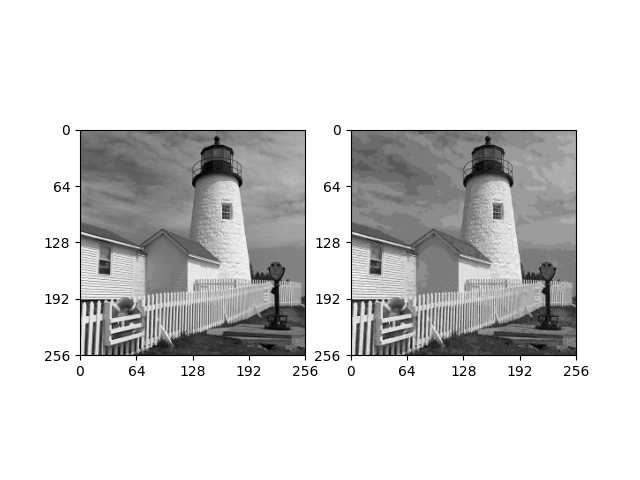

In [122]:
# Write your code to explore rms error with the laplacian pyramid here.
X1_quantise = quantise(X1, 17)
Y0_quantise = quantise(Y0, 17)

Z_0 = rowint(rowint(X1_quantise, 2*h).T, 2*h).T + Y0_quantise

fig, ax = plt.subplots(1,2)
plot_image(X, ax=ax[0]);
plot_image(Z_0, ax=ax[1]);

print("RMS error with 1 layer:", np.std(X - Z_0))

RMS error with 4 layers: 7.629817744060247


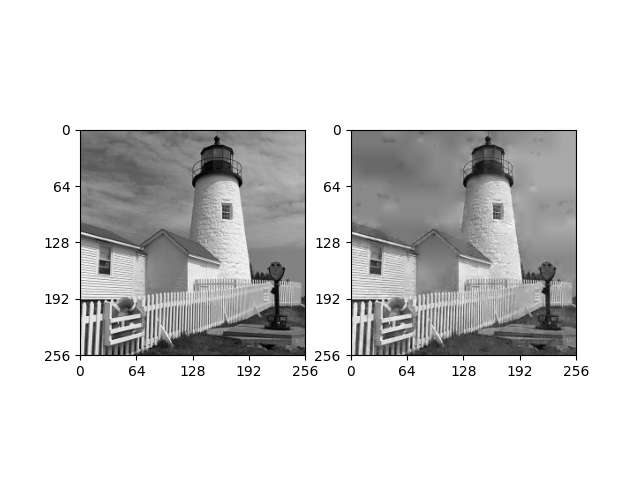

In [123]:
X4_quantise = quantise(X4, 17)
Y0_quantise = quantise(Y0, 17)
Y1_quantise = quantise(Y1, 17)
Y2_quantise = quantise(Y2, 17)
Y3_quantise = quantise(Y3, 17)

Z_3_quantise = rowint(rowint(X4_quantise, 2*h).T, 2*h).T + Y3_quantise
Z_2_quantise = rowint(rowint(Z_3_quantise, 2*h).T, 2*h).T + Y2_quantise
Z_1_quantise = rowint(rowint(Z_2_quantise, 2*h).T, 2*h).T + Y1_quantise
Z_0_quantise = rowint(rowint(Z_1_quantise, 2*h).T, 2*h).T + Y0_quantise

fig, ax = plt.subplots(1,2)
plot_image(X, ax=ax[0]);
plot_image(Z_0_quantise, ax=ax[1]);

print("RMS error with 4 layers:", np.std(X - Z_0_quantise))

In [124]:
def py_enc(X, h, num_layers):
    Y_layers = []
    current_image = X
    for _ in range(num_layers):
        downsampled = rowdec(rowdec(current_image, h).T, h).T
        laplacian_layer = current_image - rowint(rowint(downsampled, 2*h).T, 2*h).T
        Y_layers.append(laplacian_layer)
        current_image = downsampled
    return Y_layers, current_image

def py_dec(Y_layers, base_layer, h, step_size):
    current_image = quantise(base_layer, step_size)
    for laplacian_layer in reversed(Y_layers):
        current_image = rowint(rowint(current_image, 2*h).T, 2*h).T + quantise(laplacian_layer, step_size)
    return current_image

RMS error with 0 layers: 4.861168497356846
RMS error with 1 layers: 5.382782204619935
RMS error with 2 layers: 6.067419036722591
RMS error with 3 layers: 6.751868881610953
RMS error with 4 layers: 7.629817744060247
RMS error with 5 layers: 8.45124264534953
RMS error with 6 layers: 9.203373685774112
RMS error with 7 layers: 9.405961872018967
RMS error with 8 layers: 9.405961872018967


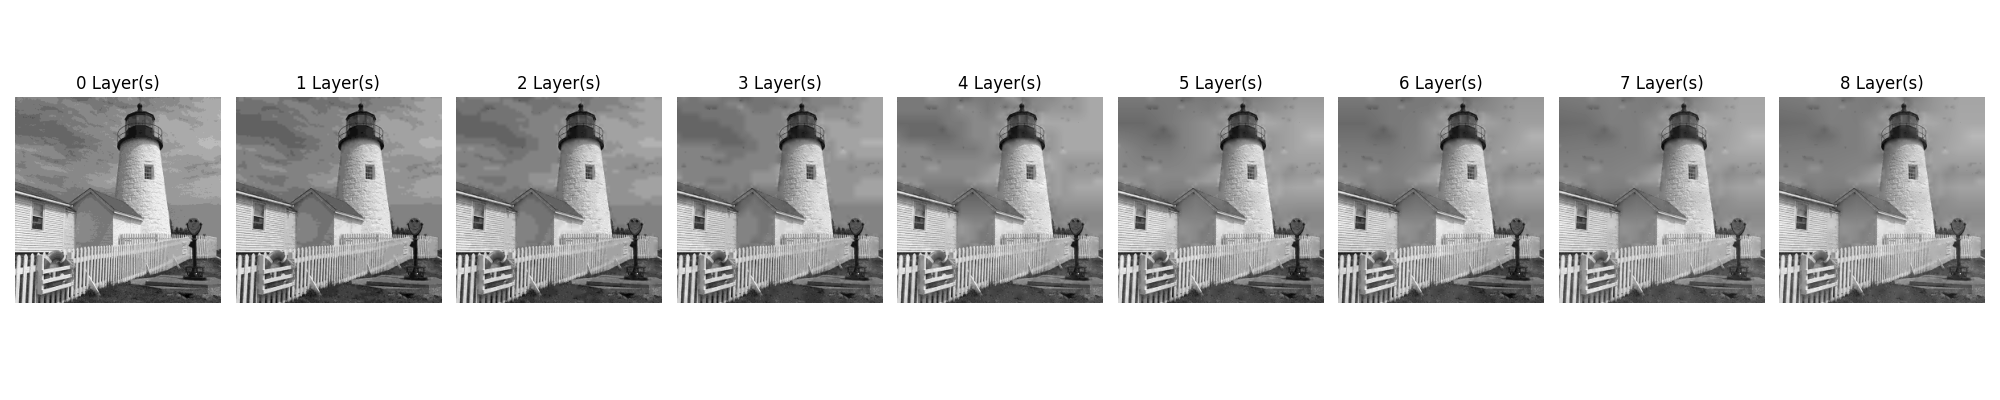

In [125]:
rms_errors = []

fig, axs = plt.subplots(1, 9, figsize=(20, 4)) 

for num_layers in range(9):
    Y_layers, current_img = py_enc(X, h, num_layers)
    recon_img = py_dec(Y_layers, current_img, h, 17)
    rms_error = np.std(X - recon_img)  
    rms_errors.append(rms_error)
    print(f"RMS error with {num_layers} layers:", rms_error)

    ax = axs[num_layers]
    ax.imshow(recon_img, cmap='gray') 
    ax.title.set_text(f'{num_layers} Layer(s)')
    ax.axis('off')  

plt.tight_layout()
plt.show()

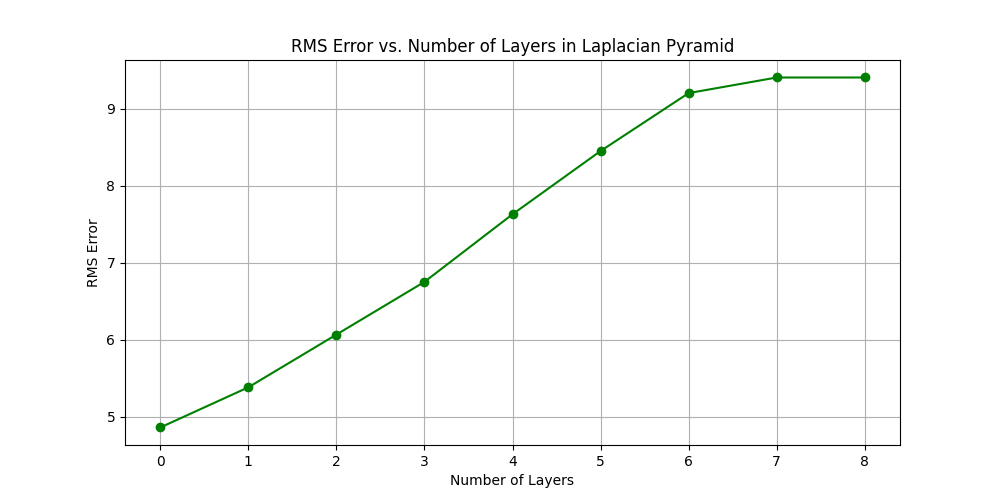

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(9), rms_errors, marker='o', linestyle='-', color='g')
plt.title('RMS Error vs. Number of Layers in Laplacian Pyramid')
plt.xlabel('Number of Layers')
plt.ylabel('RMS Error')
plt.grid(True)
plt.show()

Note that we call this error the rms error, but in fact we calculate the standard deviation, which only equals the true rms error if the mean error is zero. However the eye is very insensitive to small errors in the mean level of images, so the standard deviation (which ignores the mean) is a better measure of image quality. 

<div class="alert alert-block alert-danger">
Quantise the original image with the same step size (17) and note the visual features and rms error. Compare these results from the pyramid scheme above. Why are the rms errors larger in the pyramid scheme? 
</div>

RMS error with quantisation: 4.861168497356846


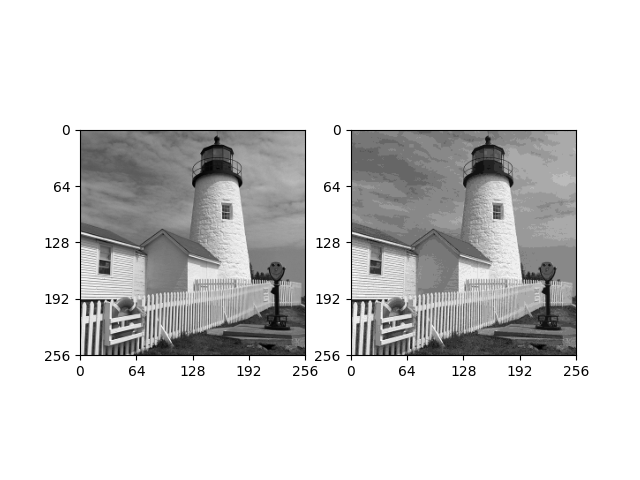

In [127]:
# Write your code to calculate the error from directly quantising the original
# image.
X_quantise = quantise(X, 17)

fig, ax = plt.subplots(1,2)
plot_image(X, ax=ax[0]);
plot_image(X_quantise, ax=ax[1]);

quantise_error_ss_17 = np.std(X - X_quantise)

print("RMS error with quantisation:", quantise_error_ss_17)

Comparisons of the number of bits with different coding strategies are only valid if they result in approximately the same image quantisation error. Write a function which will optimise the step size (resulting in a non-integer value) in the Laplacian scheme until the rms error is the same as for direct quantisation; you will find this optimisation useful for later investigations too.
<div class="alert alert-block alert-danger">
Investigate what step size of the quantisers for the pyramid scheme you need, in order to get approximately the same error as for direct quantisation at a step size of 17.
</div>

In [128]:
from scipy.optimize import minimize_scalar

def rms_error_for_step_size(step_size, X, h, num_layers, target_rms_error):
    Y_layers, current_img = py_enc(X, h, num_layers)
    recon_img = py_dec(Y_layers, current_img, h, step_size)
    rms_error = np.std(X - recon_img)
    return abs(rms_error - target_rms_error)

def find_step_size_for_rms_error_2(X, h, num_layers, target_rms_error, min_step_size=0.01, max_step_size=20, tolerance=0.12):
    result = minimize_scalar(
        rms_error_for_step_size,
        bounds=(min_step_size, max_step_size),
        args=(X, h, num_layers, target_rms_error),
        method='bounded',
        options={'xatol': tolerance}
    )
    return result.x

def investigate_quantise_error_2(X, h, target_rms_error, max_layers=7):
    step_sizes = {}
    for num_layers in range(1, max_layers + 1):
        step_size = find_step_size_for_rms_error_2(X, h, num_layers, target_rms_error)
        step_sizes[num_layers] = step_size
    return step_sizes

step_sizes_2 = investigate_quantise_error_2(X, h, quantise_error_ss_17)
print(step_sizes_2)

{1: 15.20116365428641, 2: 13.280230273438464, 3: 11.615752708999153, 4: 10.319111528791913, 5: 9.430417775942214, 6: 8.694431938679404, 7: 8.654615743296523}


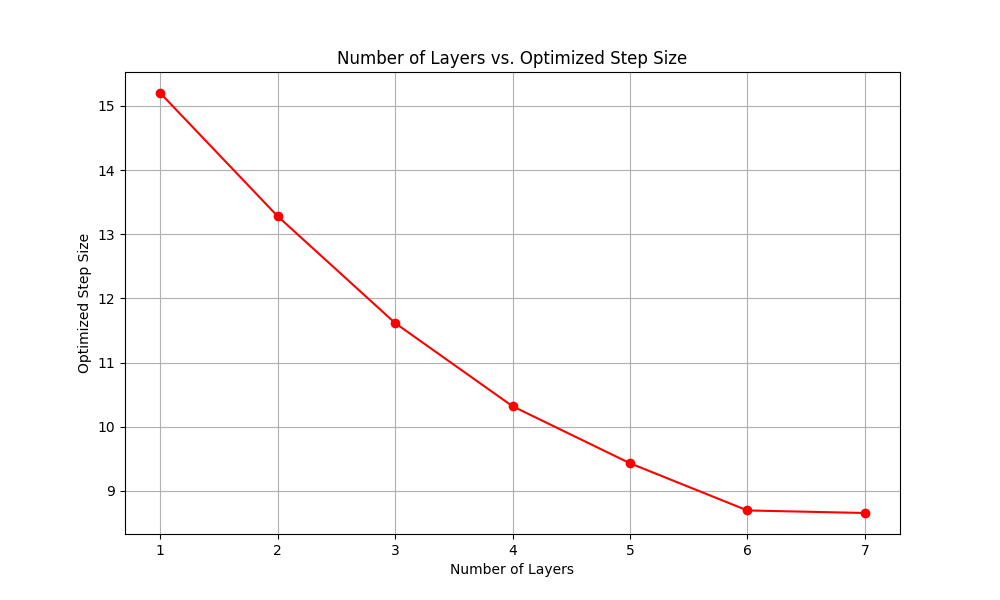

In [129]:
num_layers = list(step_sizes_2.keys())

opt_step_sizes = list(step_sizes_2.values())

plt.figure(figsize=(10, 6))
plt.plot(num_layers, opt_step_sizes, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Layers')
plt.ylabel('Optimized Step Size')
plt.title('Number of Layers vs. Optimized Step Size')
plt.grid(True)
plt.xticks(num_layers)
plt.show()


In many of your results from now on you will need to expres the performance of your algorithms in terms of *compression ratio*, which is normally defined as:

$$ \text{Compression Ratio} = \frac{\text{Total bits for reference scheme}}{\text{Total bits for compressed scheme}} $$

Usually the *reference* scheme is the direct pixel quantisation method with its quantiser adjusted to give the same rms error as the scheme being evaluated (the *compressed* scheme). For good schemes we try to make the compression ratio as large as possible.

We now investigate the effect of using different step sizes for the different levels of the pyramid. There are many schemes for varying the step sizes between different levels: in this project we shall look at the *equal MSE* criterion. In the *equal MSE* scheme, step sizes are chosen such that quantisers in each layer contribute equally to the Mean Squared Error of the reconstructed image. In general the step sizes will depend on the image signal being coded. However this can be achieved approximately by choosing a separate step size for each layer such that:
* A single impulse of that step size will give a filtered pulse in the reconstructed image which has the same energy, whichever layer of the decoder the impulse excites.

### Impulse Response Measurement
Investigate the effect of a single impulse in a particular layer (e.g. **Y0,Y1** etc.) as it appears in the reconstructed image **Z0**. This can be done by first generating a test pyramid image, which is zero everywhere. Then place an impulse (e.g. of amplitude 100) in the centre of one layer, reconstruct the entire pyramid to give **Z0**, then measure the total energy of **Z0**. If this is repeated for each layer, you will have measured how much energy a fixed size impulse at each layer contributes to the decoded image.

We actually want to arrange for the impulse sizes to vary and the energy to stay the same. Therefore the impulse sizes (and hence chosen quantisation steps) we require in each level will be inversely proportional to the square root of the energies measured above. The important result is the *ratio* of the step sizes between layers. If this ratio is maintained for any overall quantiser scaling, we will get an (approximately) *equal MSE* scheme.

<div class="alert alert-block alert-danger">
Find new values for the data compression achievable when all schemes (i.e. constant step size or equal MSE, both with varying layer depth) produce the same rms error between the decoded image and the original image. Comment on the differences in compression, visual quality and rms error, and the optimum choice of layer depth in each case.
</div>

In [130]:
# Find the compression ratios for constant step sizes 

H_X_bits = bpp(quantise(X, 17)) * X.shape[0]**2

compression_ratios = {}

for num_layers in range(1, len(step_sizes_2) + 1):
    step_size = step_sizes_2[num_layers]
    Y_layers, base_layer = py_enc(X, h, num_layers)
    
    H_X1_bits = bpp(quantise(base_layer, step_size)) * base_layer.shape[0]**2
    H_Y_layers_bits = sum(bpp(quantise(Y, step_size)) * Y.shape[0]**2 for Y in Y_layers)
    
    dc_ratio = H_X_bits / (H_X1_bits + H_Y_layers_bits)
    compression_ratios[num_layers] = dc_ratio
    print(f"Data Compression Ratio with {num_layers} layer(s):", dc_ratio)

print("Compression Ratios for each number of layers:", compression_ratios)

Data Compression Ratio with 1 layer(s): 1.3298989694339451
Data Compression Ratio with 2 layer(s): 1.389580607439098
Data Compression Ratio with 3 layer(s): 1.3251462817336799
Data Compression Ratio with 4 layer(s): 1.2498783350624225
Data Compression Ratio with 5 layer(s): 1.1925538960241588
Data Compression Ratio with 6 layer(s): 1.143699867838617
Data Compression Ratio with 7 layer(s): 1.1409759187827275
Compression Ratios for each number of layers: {1: 1.3298989694339451, 2: 1.389580607439098, 3: 1.3251462817336799, 4: 1.2498783350624225, 5: 1.1925538960241588, 6: 1.143699867838617, 7: 1.1409759187827275}


4.876497073135504


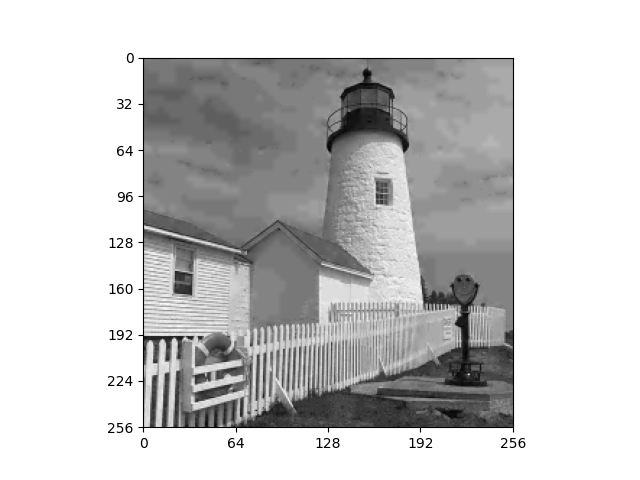

In [131]:
ss_2 = opt_step_sizes[1]

Y_layers, current_img = py_enc(X, h, 2)
recon_img = py_dec(Y_layers, current_img, h, ss_2)
rms_error = np.std(X - recon_img)

fig, ax = plt.subplots(1)
plot_image(recon_img, ax=ax);
print(np.std(X-recon_img))

In [132]:
# Find the step size ratios for equal MSE
def measure_impulse_response(h, layer_size, num_layers, impulse_position=(1,1)):
    impulse_responses = []
    for layer in range(num_layers):
        layers = [np.zeros((layer_size // (2 ** i), layer_size // (2 ** i))) for i in range(num_layers)]
        shape = (layers[layer].shape)
        impulse_position = (shape[0]//2, shape[1]//2)
        print(impulse_position)
        layers[layer][impulse_position] = 100
        base_layer = layers[-1]
        layers = layers[:-1]
        Z0 = py_dec(layers, base_layer, h, step_size = 1)
        energy = (np.sum(Z0 ** 2))
        impulse_responses.append(energy)
    return impulse_responses

def compute_step_sizes(impulse_responses):
    ratios = [np.sqrt(impulse_responses[0] / energy) for energy in impulse_responses]
    return ratios

num_layers = 8
layer_size = 256

impulse_responses = measure_impulse_response(h, layer_size, num_layers)

step_size_ratios = compute_step_sizes(impulse_responses)

print(impulse_responses)
print("Step Size Ratios:", step_size_ratios)

(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)
(2, 2)
(1, 1)
[10000.0, 22500.0, 75625.0, 288906.25, 1142226.5625, 4555556.640625, 18208889.16015625, 289571375.88500977]
Step Size Ratios: [1.0, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697, 0.0935672514619883, 0.04685212298682284, 0.02343463932625412, 0.005876546610655832]


In [133]:
# Find the quantisation step size for equal mse, matching the reference RMS error
from scipy.optimize import minimize_scalar

def py_dec(Y_layers, base_layer, h, step_sizes):
    current_image = quantise(base_layer, step_sizes[-1])
    for i, laplacian_layer in enumerate(reversed(Y_layers)):
        current_image = rowint(rowint(current_image, 2 * h).T, 2 * h).T + quantise(laplacian_layer, step_sizes[-(i+1)])
    return current_image

def measure_impulse_response(h, layer_size, num_layers, impulse_position=(0, 0)):
    impulse_responses = []
    for layer in range(num_layers):
        layers = [np.zeros((layer_size // (2 ** i), layer_size // (2 ** i))) for i in range(num_layers)]
        layers[layer][impulse_position] = 100
        base_layer = layers[-1]
        layers = layers[:-1]
        Z0 = py_dec(layers, base_layer, h, [1] * num_layers)
        energy = np.sum(Z0 ** 2)
        impulse_responses.append(energy)
    return impulse_responses


def rms_error_for_step_size(step_size, X, h, num_layers, step_size_ratios, target_rms_error):
    Y_layers, current_img = py_enc(X, h, num_layers)
    step_sizes = [step_size * ratio for ratio in step_size_ratios]
    recon_img = py_dec(Y_layers, current_img, h, step_sizes)
    rms_error = np.std(X - recon_img)
    return abs(rms_error - target_rms_error)

def find_overall_step_size(X, h, num_layers, step_size_ratios, target_rms_error, min_step_size=0.01, max_step_size=50, tolerance=0.01):
    result = minimize_scalar(
        rms_error_for_step_size,
        bounds=(min_step_size, max_step_size),
        args=(X, h, num_layers, step_size_ratios, target_rms_error),
        method='bounded',
        options={'xatol': tolerance}
    )
    return result.x

num_layers = 8 
layer_size = 256 
target_rms_error = quantise_error_ss_17

overall_step_size = find_overall_step_size(X, h, num_layers, step_size_ratios, target_rms_error)

final_step_sizes = [overall_step_size * ratio for ratio in step_size_ratios]

print("Impulse Responses:", impulse_responses)
print("Step Size Ratios:", step_size_ratios)
print("Overall Step Size:", overall_step_size)
print("Final Step Sizes for Each Layer:", final_step_sizes)

Impulse Responses: [10000.0, 22500.0, 75625.0, 288906.25, 1142226.5625, 4555556.640625, 18208889.16015625, 289571375.88500977]
Step Size Ratios: [1.0, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697, 0.0935672514619883, 0.04685212298682284, 0.02343463932625412, 0.005876546610655832]
Overall Step Size: 18.057713218001812
Final Step Sizes for Each Layer: [18.057713218001812, 12.038475478667873, 6.566441170182477, 3.3595745521863836, 1.6896105934972454, 0.8460422005505973, 0.4231759963208041, 0.10611699340744357]


In [134]:
# Find the compression ratios for equal mse
H_X_bits = bpp(quantise(X, 17)) * X.shape[0]**2

compression_ratios_2 = {}

for num_layers in range(1, len(final_step_sizes)):
    Y_layers, base_layer = py_enc(X, h, num_layers)
    
    # Quantize the base layer using the (num_layers+1)-th step size
    step_size_bl = final_step_sizes[num_layers]
    H_bl_bits = bpp(quantise(base_layer, step_size_bl)) * base_layer.shape[0]**2
    
    # Quantize each Y layer using the respective step sizes from 1st to num_layers
    H_Y_layers_bits = 0
    for i in range(num_layers):
        step_size_Y = final_step_sizes[i]
        H_Y_layers_bits += bpp(quantise(Y_layers[i], step_size_Y)) * Y_layers[i].shape[0]**2
    
    # Calculate the data compression ratio
    dc_ratio = H_X_bits / (H_bl_bits + H_Y_layers_bits)
    compression_ratios_2[num_layers] = dc_ratio
    print(f"Data Compression Ratio with {num_layers} layer(s):", dc_ratio)

print("Compression Ratios for each number of layers:", compression_ratios_2)

Data Compression Ratio with 1 layer(s): 1.3729372717286312
Data Compression Ratio with 2 layer(s): 1.51867752893785
Data Compression Ratio with 3 layer(s): 1.5467957395741632
Data Compression Ratio with 4 layer(s): 1.548351192159689
Data Compression Ratio with 5 layer(s): 1.5474600301894523
Data Compression Ratio with 6 layer(s): 1.546947525374951
Data Compression Ratio with 7 layer(s): 1.546913483785048
Compression Ratios for each number of layers: {1: 1.3729372717286312, 2: 1.51867752893785, 3: 1.5467957395741632, 4: 1.548351192159689, 5: 1.5474600301894523, 6: 1.546947525374951, 7: 1.546913483785048}


## 6.3 Changing the decimation / interpolation filter
It is also worth investigating whether a more complicated decimation / interpolation filter **h** can improve the compression. The z-transfer function of the filter used so far is

$$ h(z) = \left(\frac{1 + z^{-1}}{2}\right)^m $$

where $m = 2$. If $m$ is increased to 4(so the number of taps remains odd), the vector representation of **h** is \[1/16 4/16 6/16 4/16 1/16\]. This filter has a lower cut-off frequency than when $m=2$, so you should find that each interpolated lowpass image in the pyramid is a little more blurred, and there is a little more energy left in each highpass image.

<div class="alert alert-block alert-danger">
Optimise the step sizes for the pyramid with this new filter and determine the new compression performance and visual features.
</div>

In [135]:
# Repeat the previous experiments with a new h here
h = np.array([1, 4, 6, 4, 1]) / 16.0

In [136]:
from scipy.optimize import minimize_scalar

def py_enc(X, h, num_layers):
    Y_layers = []
    current_image = X
    for _ in range(num_layers):
        downsampled = rowdec(rowdec(current_image, h).T, h).T
        laplacian_layer = current_image - rowint(rowint(downsampled, 2*h).T, 2*h).T
        Y_layers.append(laplacian_layer)
        current_image = downsampled
    return Y_layers, current_image

def py_dec(Y_layers, base_layer, h, step_size):
    current_image = quantise(base_layer, step_size)
    for laplacian_layer in reversed(Y_layers):
        current_image = rowint(rowint(current_image, 2*h).T, 2*h).T + quantise(laplacian_layer, step_size)
    return current_image

def rms_error_for_step_size(step_size, X, h, num_layers, target_rms_error):
    Y_layers, current_img = py_enc(X, h, num_layers)
    recon_img = py_dec(Y_layers, current_img, h, step_size)
    rms_error = np.std(X - recon_img)
    return abs(rms_error - target_rms_error)

def find_step_size_for_rms_error_2(X, h, num_layers, target_rms_error, min_step_size=0.1, max_step_size=20, tolerance=0.1):
    result = minimize_scalar(
        rms_error_for_step_size,
        bounds=(min_step_size, max_step_size),
        args=(X, h, num_layers, target_rms_error),
        method='bounded',
        options={'xatol': tolerance}
    )
    return result.x

def investigate_quantise_error_2(X, h, target_rms_error, max_layers=7):
    step_sizes = {}
    for num_layers in range(1, max_layers + 1):
        step_size = find_step_size_for_rms_error_2(X, h, num_layers, target_rms_error)
        step_sizes[num_layers] = step_size
    return step_sizes

step_sizes_3 = investigate_quantise_error_2(X, h, quantise_error_ss_17)
print(step_sizes_3)

{1: 16.268881079350013, 2: 14.36069324462592, 3: 12.694288216063388, 4: 11.510105708074509, 5: 11.271524685401394, 6: 10.102830980342155, 7: 10.181251338735684}


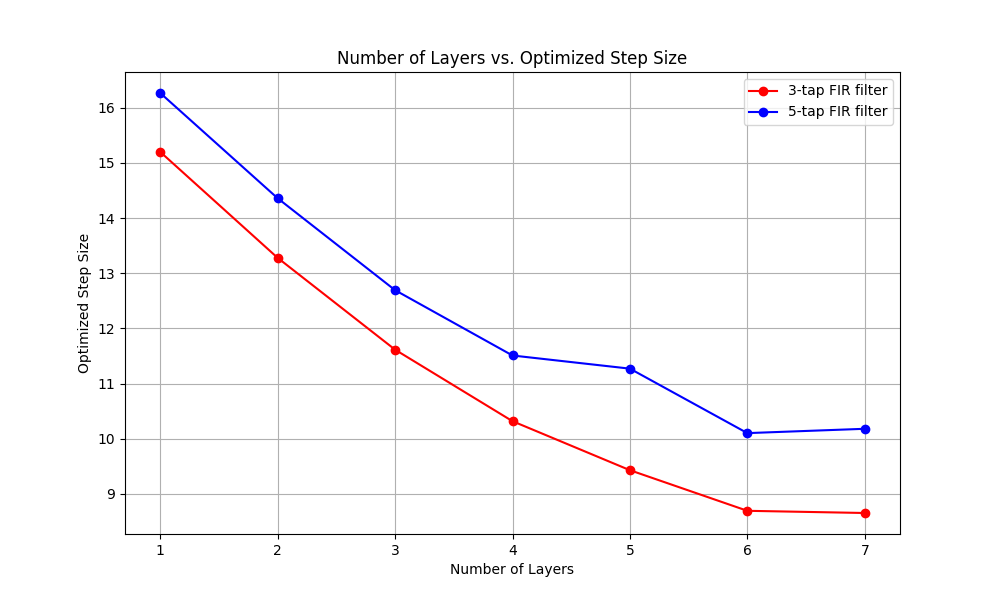

In [137]:
num_layers = list(step_sizes_2.keys())

opt_step_sizes = list(step_sizes_2.values())
opt_step_sizes_2 = list(step_sizes_3.values())

plt.figure(figsize=(10, 6))
plt.plot(num_layers, opt_step_sizes, marker='o', linestyle='-', color='r', label='3-tap FIR filter')
plt.plot(num_layers, opt_step_sizes_2, marker='o', linestyle='-', color='b', label='5-tap FIR filter')
plt.xlabel('Number of Layers')
plt.ylabel('Optimized Step Size')
plt.title('Number of Layers vs. Optimized Step Size')
plt.grid(True)
plt.legend()
plt.xticks(num_layers)
plt.show()

In [138]:
H_X_bits = bpp(quantise(X, 17)) * X.shape[0]**2

compression_ratios_3 = {}

for num_layers in range(1, len(step_sizes_3) + 1):
    step_size = step_sizes_3[num_layers]
    Y_layers, base_layer = py_enc(X, h, num_layers)
    
    H_X1_bits = bpp(quantise(base_layer, step_size)) * base_layer.shape[0]**2
    H_Y_layers_bits = sum(bpp(quantise(Y, step_size)) * Y.shape[0]**2 for Y in Y_layers)
    
    dc_ratio = H_X_bits / (H_X1_bits + H_Y_layers_bits)
    compression_ratios_3[num_layers] = dc_ratio
    print(f"Data Compression Ratio with {num_layers} layer(s):", dc_ratio)

print("Compression Ratios for each number of layers:", compression_ratios_3)

Data Compression Ratio with 1 layer(s): 1.276939663039829
Data Compression Ratio with 2 layer(s): 1.3310586631940113
Data Compression Ratio with 3 layer(s): 1.2746177466542867
Data Compression Ratio with 4 layer(s): 1.2115782484730384
Data Compression Ratio with 5 layer(s): 1.1986034625988367
Data Compression Ratio with 6 layer(s): 1.133647800070026
Data Compression Ratio with 7 layer(s): 1.1376470957395903
Compression Ratios for each number of layers: {1: 1.276939663039829, 2: 1.3310586631940113, 3: 1.2746177466542867, 4: 1.2115782484730384, 5: 1.1986034625988367, 6: 1.133647800070026, 7: 1.1376470957395903}


4.863452834999838


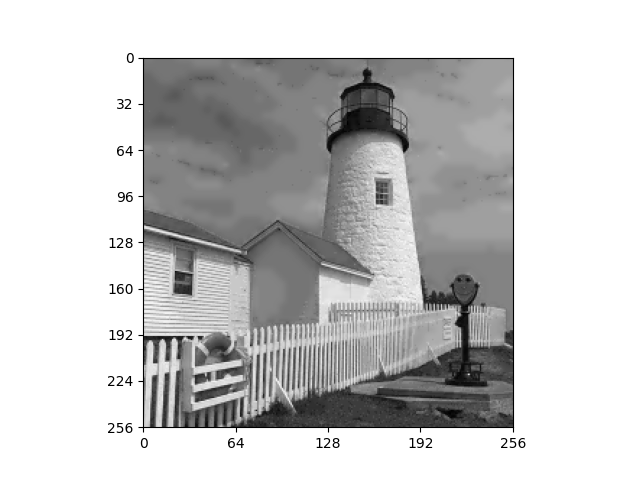

In [139]:
ss_3 = opt_step_sizes_2[1]

Y_layers, current_img = py_enc(X, h, 2)
recon_img = py_dec(Y_layers, current_img, h, ss_3)
rms_error = np.std(X - recon_img)

fig, ax = plt.subplots(1)
plot_image(recon_img, ax=ax);
print(np.std(X-recon_img))

In [140]:
# Find the step size ratios for equal MSE
def measure_impulse_response(h, layer_size, num_layers, impulse_position=(1,1)):
    impulse_responses = []
    for layer in range(num_layers):
        layers = [np.zeros((layer_size // (2 ** i), layer_size // (2 ** i))) for i in range(num_layers)]
        shape = (layers[layer].shape)
        impulse_position = (shape[0]//2, shape[1]//2)
        print(impulse_position)
        layers[layer][impulse_position] = 100
        base_layer = layers[-1]
        layers = layers[:-1]
        Z0 = py_dec(layers, base_layer, h, step_size = 1)
        energy = (np.sum(Z0 ** 2))
        impulse_responses.append(energy)
    return impulse_responses

def compute_step_sizes(impulse_responses):
    ratios = [np.sqrt(impulse_responses[0] / energy) for energy in impulse_responses]
    return ratios

num_layers = 8
layer_size = 256

impulse_responses = measure_impulse_response(h, layer_size, num_layers)

step_size_ratios = compute_step_sizes(impulse_responses)

print(impulse_responses)
print("Step Size Ratios:", step_size_ratios)

(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)
(2, 2)
(1, 1)
[10000.0, 11962.890625, 39029.39796447754, 149228.19928266108, 590402.9486393938, 2355191.0562699796, 9414365.412980707, 250385626.8809008]
Step Size Ratios: [1.0, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054, 0.13014447658344933, 0.06516087811520659, 0.03259150941051387, 0.006319683119085564]


In [141]:
def py_dec(Y_layers, base_layer, h, step_sizes):
    current_image = quantise(base_layer, step_sizes[-1])
    for i, laplacian_layer in enumerate(reversed(Y_layers)):
        current_image = rowint(rowint(current_image, 2 * h).T, 2 * h).T + quantise(laplacian_layer, step_sizes[-(i+1)])
    return current_image

def measure_impulse_response(h, layer_size, num_layers, impulse_position=(0, 0)):
    impulse_responses = []
    for layer in range(num_layers):
        layers = [np.zeros((layer_size // (2 ** i), layer_size // (2 ** i))) for i in range(num_layers)]
        layers[layer][impulse_position] = 100
        base_layer = layers[-1]
        layers = layers[:-1]
        Z0 = py_dec(layers, base_layer, h, [1] * num_layers)
        energy = np.sum(Z0 ** 2)
        impulse_responses.append(energy)
    return impulse_responses


def rms_error_for_step_size(step_size, X, h, num_layers, step_size_ratios, target_rms_error):
    Y_layers, current_img = py_enc(X, h, num_layers)
    step_sizes = [step_size * ratio for ratio in step_size_ratios]
    recon_img = py_dec(Y_layers, current_img, h, step_sizes)
    rms_error = np.std(X - recon_img)
    return abs(rms_error - target_rms_error)

def find_overall_step_size(X, h, num_layers, step_size_ratios, target_rms_error, min_step_size=0.01, max_step_size=50, tolerance=0.5):
    result = minimize_scalar(
        rms_error_for_step_size,
        bounds=(min_step_size, max_step_size),
        args=(X, h, num_layers, step_size_ratios, target_rms_error),
        method='bounded',
        options={'xatol': tolerance}
    )
    return result.x

num_layers = 8 
layer_size = 256 
target_rms_error = quantise_error_ss_17

overall_step_size = find_overall_step_size(X, h, num_layers, step_size_ratios, target_rms_error)

final_step_sizes_2 = [overall_step_size * ratio for ratio in step_size_ratios]

print("Impulse Responses:", impulse_responses)
print("Step Size Ratios:", step_size_ratios)
print("Overall Step Size:", overall_step_size)
print("Final Step Sizes for Each Layer:", final_step_sizes_2)

Impulse Responses: [10000.0, 11962.890625, 39029.39796447754, 149228.19928266108, 590402.9486393938, 2355191.0562699796, 9414365.412980707, 250385626.8809008]
Step Size Ratios: [1.0, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054, 0.13014447658344933, 0.06516087811520659, 0.03259150941051387, 0.006319683119085564]
Overall Step Size: 16.69059372190745
Final Step Sizes for Each Layer: [16.69059372190745, 15.259971402886812, 8.448427074262595, 4.320622635578737, 2.1721885838046506, 1.0875737431836436, 0.5439716423546104, 0.10547926339185401]


In [142]:
H_X_bits = bpp(quantise(X, 17)) * X.shape[0]**2

compression_ratios_4 = {}

for num_layers in range(1, len(final_step_sizes_2)):
    Y_layers, base_layer = py_enc(X, h, num_layers)
    
    # Quantize the base layer using the (num_layers+1)-th step size
    step_size_bl = final_step_sizes_2[num_layers]
    H_bl_bits = bpp(quantise(base_layer, step_size_bl)) * base_layer.shape[0]**2
    
    # Quantize each Y layer using the respective step sizes from 1st to num_layers
    H_Y_layers_bits = 0
    for i in range(num_layers):
        step_size_Y = final_step_sizes_2[i]
        H_Y_layers_bits += bpp(quantise(Y_layers[i], step_size_Y)) * Y_layers[i].shape[0]**2
    
    # Calculate the data compression ratio
    dc_ratio = H_X_bits / (H_bl_bits + H_Y_layers_bits)
    compression_ratios_4[num_layers] = dc_ratio
    print(f"Data Compression Ratio with {num_layers} layer(s):", dc_ratio)

print("Compression Ratios for each number of layers:", compression_ratios_4)

Data Compression Ratio with 1 layer(s): 1.2810125090392648
Data Compression Ratio with 2 layer(s): 1.4002010987677844
Data Compression Ratio with 3 layer(s): 1.421456568397848
Data Compression Ratio with 4 layer(s): 1.4213448656281686
Data Compression Ratio with 5 layer(s): 1.4201997588172923
Data Compression Ratio with 6 layer(s): 1.4199453330044849
Data Compression Ratio with 7 layer(s): 1.4198923035998205
Compression Ratios for each number of layers: {1: 1.2810125090392648, 2: 1.4002010987677844, 3: 1.421456568397848, 4: 1.4213448656281686, 5: 1.4201997588172923, 6: 1.4199453330044849, 7: 1.4198923035998205}


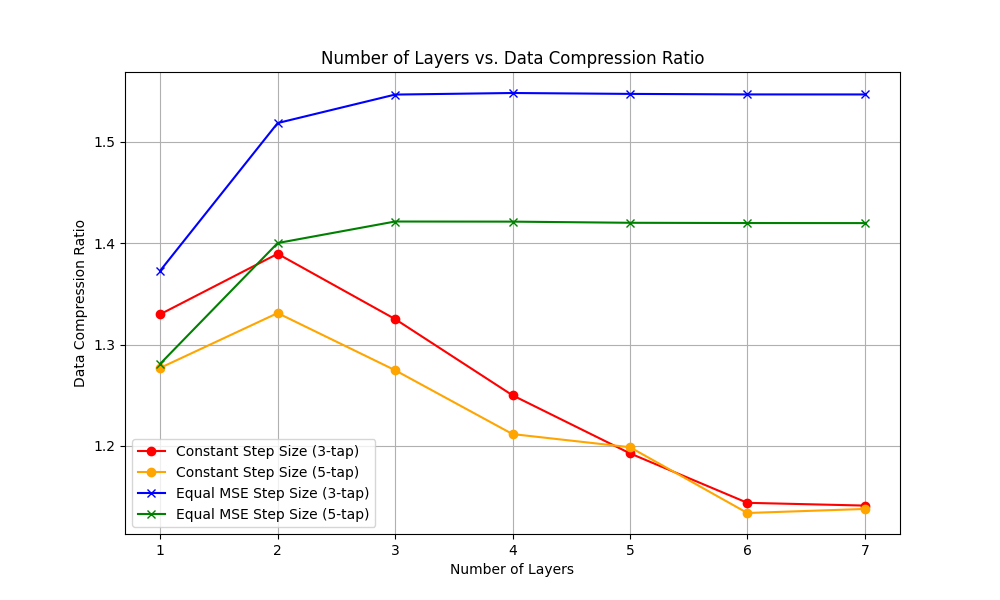

In [143]:
num_layers = list(compression_ratios.keys())

const_ss_3tf = list(compression_ratios.values())
equalmse_ss_3tf = list(compression_ratios_2.values())

const_ss_5tf = list(compression_ratios_3.values())
equalmse_ss_5tf = list(compression_ratios_4.values())

plt.figure(figsize=(10, 6))
plt.plot(num_layers, const_ss_3tf, marker='o', linestyle='-', color='r', label='Constant Step Size (3-tap)')
plt.plot(num_layers, const_ss_5tf, marker='o', linestyle='-', color='orange', label='Constant Step Size (5-tap)')
plt.plot(num_layers, equalmse_ss_3tf, marker='x', linestyle='-', color='b', label='Equal MSE Step Size (3-tap)')
plt.plot(num_layers, equalmse_ss_5tf, marker='x', linestyle='-', color='g', label='Equal MSE Step Size (5-tap)')
plt.xlabel('Number of Layers')
plt.ylabel('Data Compression Ratio')
plt.title('Number of Layers vs. Data Compression Ratio')
plt.grid(True)
plt.legend()
plt.xticks(num_layers)
plt.show()

In [144]:
print(const_ss_3tf)
print(const_ss_5tf)
print(equalmse_ss_3tf)
print(equalmse_ss_5tf)



[1.3298989694339451, 1.389580607439098, 1.3251462817336799, 1.2498783350624225, 1.1925538960241588, 1.143699867838617, 1.1409759187827275]
[1.276939663039829, 1.3310586631940113, 1.2746177466542867, 1.2115782484730384, 1.1986034625988367, 1.133647800070026, 1.1376470957395903]
[1.3729372717286312, 1.51867752893785, 1.5467957395741632, 1.548351192159689, 1.5474600301894523, 1.546947525374951, 1.546913483785048]
[1.2810125090392648, 1.4002010987677844, 1.421456568397848, 1.4213448656281686, 1.4201997588172923, 1.4199453330044849, 1.4198923035998205]


# First Interim Report
Discuss and explain your results, gathered so far, in your first interim report. Try to answer the questions posed in the above test. Be brief where things are straightforward, but pay more attention to detail in areas where you think something interesting is happening. Write this as a standalone report, not as a series of bullet points answering the questions posed.